# Data Exploration
In this Python notebook, we aim to pre-process the data by:
- examining the contents of the dataset
- handling missing values and outliers
- ensuring consistency of formatting

We also attempt to carry out initial tasks for:
- Natural Language Processing
- Time Series Analysis
- Data Visualization

## Importing and Reading the Dataset
Note: Dataset imported is a concatenation of the submitted datasets as well as tweets between **Dec 25, 2021** (45 days before start of campaign period) to **June 23, 2022** (45 days after elections).

In [51]:
#@title
import pandas as pd
import io
 
df = pd.read_csv('https://raw.githubusercontent.com/jareddantis/cs132-group3/main/data-exploration/group03_dataset_compiled.csv')
pd.set_option('display.max_colwidth', None)
df.head().style.set_properties(**{'text-align': 'left'})

,ID,Timestamp,Tweet URL,Group,Collector,Category,Topic,Keywords,Account handle,Account name,Account bio,"Account type ""Identified Anonymous Media""",Joined,Following,Followers,Location,Tweet,Tweet Translated,Tweet Type,Tweet Type (2),Tweet Type (3),Date posted,Screenshot,Content type,Likes,Replies,Retweets,Quote Tweets,Views,Rating,Reasoning,Remarks,Tweet ID,Unnamed: 33
0,00-1,03/28/23 14:12:00,https://twitter.com/jobbautista9/status/1475113095395966978,3,"Adorna, Juris Hannah",REDT,Neri Colmenares is affiliated with the CPP-NPA-NDF / is an ex-cadre of the CPP,cpp neri,@jobbautista9,Job Bautista #RejectSIMCardReg,College student studying computer science Mima-sama pfp by @ogami2160 Mastodon: @job@tilde.zone Plurk: plurk.com/jobbautista9 GPG can be found at my site,Identified,12/13,580,282,"Dasmariñas, Cavite","@_ultravioletred @jersonality If their ED was done by a CPP cadre, the educator would've been reprimanded for sure. Whoever that educator is, they're probably still thinking in the 90s. Wake up kas, RA/RJ split is not that relevant anymore, lol. Embrace your comrades like what Neri, Labog, and Zarate did.",nan,Reply,nan,nan,12/26/21 22:35,00-1.png,Rational,1,0,0,0,nan,Inaccurate,"""Embracing comrades"" implies a fabricated affiliation of Neri to ex-cadres",,1475113095395966976,jobbautista9
1,00-2,03/28/23 14:12:00,https://twitter.com/SeanAlden8/status/1475699422982189061,3,"Adorna, Juris Hannah",REDT,Neri Colmenares is affiliated with the CPP-NPA-NDF / is an ex-cadre of the CPP,npa neri,@SeanAlden8,Sean Alden,nan,Identified,11/22,618,62,nan,@lukatmhe Colmenarez family ay part sa legal front ng NPA. At saka my first cousin si Angel Locsin na big time drug dealer ng shabu sa Cebu. Siya at former Local Beauty Queen. Mismo si Neri Colmenarez naki usap sa mnga police na wag galawin or itumba.,nan,Reply,nan,nan,12/28/21 13:25,00-2.png,Rational,0,1,0,0,nan,Fake,Fabrication of ties of the Colmenares family to the CPP [1] [2],No location was given. No Bio was given.,1475699422982189056,SeanAlden8
2,00-3,03/28/23 14:12:00,https://twitter.com/dozZ3h_Vbril/status/1476173017458016256,3,"Adorna, Juris Hannah",REDT,Neri Colmenares is affiliated with the CPP-NPA-NDF / is an ex-cadre of the CPP,npa colmenares,@dozZ3h_Vbril,t ❤_💚 k! rO ツ,â¤ðŸ’šâœŒðŸ‘Š,Anonymous,09/03,2147,3130,nan,"@weirdnow1 @pnagovph yay ðŸ˜‚ðŸ˜‚ðŸ˜‚ kaya pa nmn mag pakamatay yang sina Elago,Zarate,Colmenares,Nato Reyes sa pakiki bakbakan.Tanggaaa yung mga nasapi sa NPA",nan,Reply,nan,nan,12/29/21 20:47,00-3.png,Emotional,2,1,0,0,nan,Needs context,Listed progressive candidates before maliciously looping in the CPP into the statement,No location was given.,1476173017458016256,dozZ3h_Vbril
3,00-4,03/28/23 14:12:00,https://twitter.com/Angieskie07/status/1479341371219902468,3,"Adorna, Juris Hannah",REDT,Neri Colmenares is affiliated with the CPP-NPA-NDF / is an ex-cadre of the CPP,npa colmenares,@Angieskie07,DareDevil Queen,nan,Anonymous,09/11,51,25,nan,@ColmenaresPH Shut Up Colmenares NPA. SALOT KA #Nerveagain,nan,Reply,nan,nan,01/07/22 14:37,00-4.png,Emotional,1,0,0,0,nan,Fake,Fabrication of Colmenares' ties to the CPP [1] [2],No location was given. No Bio was given.,1479341371219902464,Angieskie07
4,00-5,03/28/23 14:12:00,https://twitter.com/ghearrrrr/status/1479580070922846209,3,"Adorna, Juris Hannah",REDT,Neri Colmenares is affiliated with the CPP-NPA-NDF / is an ex-cadre of the CPP,npa neri,@ghearrrrr,ghear,leah hakdog,Anonymous,09/11,303,341,"General Trias, Calabarzon",AHAHAHAHA neri niyo NPA,nan,Reply,nan,nan,01/08/22 06:25,00-5.png,Emotional,0,0,0,0,nan,Fake,"QRT'd a tweet asking the Marcoses for accountability, fabrication of Colmenares' ties to the NPA as a response",,1479580070922846208,ghearrrrr


### General Characteristics and Properties of the Dataframe

The dataset is formatted similarly to the required submissions for the Data Gathering phase. However, since the submitted data is not evenly sampled across the dates, the proponents had to supplement the submitted data set to the rest of the tweets scraped.

In [52]:
from tabulate import tabulate

print("Shape of the Dataframe: ", df.shape)
print("-"*30)
print("Number of columns: ", df.shape[1])
print("-"*30)
print("Data Types of columns:")
print(df.dtypes)
print("-"*30)
print("Missing values per column:")
print(df.isna().sum())
print("-"*30)
print("Range of values for each numeric column in the dataset")


Shape of the Dataframe:  (249, 34)
------------------------------
Number of columns:  34
------------------------------
Data Types of columns:
ID                                               object
Timestamp                                        object
Tweet URL                                        object
Group                                             int64
Collector                                        object
Category                                         object
Topic                                            object
Keywords                                         object
Account handle                                   object
Account name                                     object
Account bio                                      object
Account type\n"Identified\nAnonymous\nMedia"     object
Joined                                           object
Following                                         int64
Followers                                         int64
Location         

In [53]:
print('Minimum value per column:')
print(df.min(numeric_only=True))
print("-"*30)
print('Maximum value per column:')
print(df.max(numeric_only=True))
print("-"*30)

Minimum value per column:
Group               3.000000e+00
Following           0.000000e+00
Followers           0.000000e+00
Tweet Translated             NaN
Likes               0.000000e+00
Replies             0.000000e+00
Retweets            0.000000e+00
Quote Tweets        0.000000e+00
Views                        NaN
Tweet ID            1.475113e+18
dtype: float64
------------------------------
Maximum value per column:
Group               3.000000e+00
Following           6.461000e+03
Followers           2.160500e+04
Tweet Translated             NaN
Likes               1.160000e+02
Replies             8.000000e+00
Retweets            5.700000e+01
Quote Tweets        2.200000e+01
Views                        NaN
Tweet ID            1.538748e+18
dtype: float64
------------------------------


# Pre-processing

### Identifying necessary features
The first step to pre-processing the data is identifying which features are relevant to the project. The goal is to create a new dataframe that only contains features that we're interested in using.

The features we've identified to be relevant to our project are:

1.   ID - which allows us to cross-check data and keep track of each column in the dataframe and Google Sheet.
2.   Account Type (Identified, Anonymous, Media) - which allows us to identify which types of accounts posted at which times
3.   Tweet Type (Text, Image, Video, URL, Reply) - which allows us to identify which types of tweets are posted at which times
4.   Date Posted - which allows us to identify what time the scraped tweets were posted and inspect its relationship with the campaign period
5.   Screenshot - which allows us to cross-check the content in its entirety (account posting, content of post, corresponding types, and the time of posting)
6.   Tweet ID - which allows us to identify each tweet uniquely

In addition to these features, we've also retained the following rows for compliance to the NLP requirement in the EDA:
1.   Tweet - which allows us to consider the contents of the tweet itself for analysis
2.   Content type - which allows us to look at the relationship between the contents of the tweet and its type as identified by the proponents

In [54]:
df_new = df.copy()
columns_to_keep = ['Timestamp','Tweet URL', 'Topic', 'Group','Collector','Category','Keywords','Account handle','Account name', 'Account bio', 'Joined', 'Following', 'Followers', 'Location', 'Tweet Translated','Likes','Replies','Retweets','Quote Tweets','Views','Rating','Reasoning','Remarks']
for i in columns_to_keep:
  df_new = df_new.drop(i, axis=1)
df_new = df_new.iloc[: , :-1]
df_new.head().style.set_properties(**{'text-align': 'left'})

,ID,"Account type ""Identified Anonymous Media""",Tweet,Tweet Type,Tweet Type (2),Tweet Type (3),Date posted,Screenshot,Content type,Tweet ID
0,00-1,Identified,"@_ultravioletred @jersonality If their ED was done by a CPP cadre, the educator would've been reprimanded for sure. Whoever that educator is, they're probably still thinking in the 90s. Wake up kas, RA/RJ split is not that relevant anymore, lol. Embrace your comrades like what Neri, Labog, and Zarate did.",Reply,nan,nan,12/26/21 22:35,00-1.png,Rational,1475113095395966976
1,00-2,Identified,@lukatmhe Colmenarez family ay part sa legal front ng NPA. At saka my first cousin si Angel Locsin na big time drug dealer ng shabu sa Cebu. Siya at former Local Beauty Queen. Mismo si Neri Colmenarez naki usap sa mnga police na wag galawin or itumba.,Reply,nan,nan,12/28/21 13:25,00-2.png,Rational,1475699422982189056
2,00-3,Anonymous,"@weirdnow1 @pnagovph yay ðŸ˜‚ðŸ˜‚ðŸ˜‚ kaya pa nmn mag pakamatay yang sina Elago,Zarate,Colmenares,Nato Reyes sa pakiki bakbakan.Tanggaaa yung mga nasapi sa NPA",Reply,nan,nan,12/29/21 20:47,00-3.png,Emotional,1476173017458016256
3,00-4,Anonymous,@ColmenaresPH Shut Up Colmenares NPA. SALOT KA #Nerveagain,Reply,nan,nan,01/07/22 14:37,00-4.png,Emotional,1479341371219902464
4,00-5,Anonymous,AHAHAHAHA neri niyo NPA,Reply,nan,nan,01/08/22 06:25,00-5.png,Emotional,1479580070922846208


### Examining the general characteristics

Now that we've created a dataframe with only the data that we need for the EDA and the project as a whole, we can look at the general characteristics of the dataframe to help us as we go along.

In [55]:
from tabulate import tabulate

print("Shape of the Dataframe: ", df_new.shape)
print("-"*30)
print("Number of columns: ", df_new.shape[1])
print("-"*30)
print("Data Types of columns:")
print(df_new.dtypes)
print("-"*30)
print("Missing values per column:")
print(df_new.isna().sum())
print("-"*30)
print("Range of values for each numeric column in the dataset")

Shape of the Dataframe:  (249, 10)
------------------------------
Number of columns:  10
------------------------------
Data Types of columns:
ID                                              object
Account type\n"Identified\nAnonymous\nMedia"    object
Tweet                                           object
Tweet Type                                      object
Tweet Type (2)                                  object
Tweet Type (3)                                  object
Date posted                                     object
Screenshot                                      object
Content type                                    object
Tweet ID                                         int64
dtype: object
------------------------------
Missing values per column:
ID                                                0
Account type\n"Identified\nAnonymous\nMedia"      0
Tweet                                             0
Tweet Type                                        0
Tweet Type (2)             

### Checking for duplicate entries

Before exporting the complete dataset to a CSV format, the duplicates have already been removed. To verify this, we look for duplicate values across all columns. To show that there are no duplicates, the dataframe `duplicates` is shown to be empty.

In [56]:
duplicates = df_new[df_new.duplicated()]

print("Number of rows in duplicates: ", duplicates.shape[0])
print("Duplicate Rows :")
duplicates.style.set_properties(**{'text-align': 'left'})


Number of rows in duplicates:  0
Duplicate Rows :


,ID,"Account type ""Identified Anonymous Media""",Tweet,Tweet Type,Tweet Type (2),Tweet Type (3),Date posted,Screenshot,Content type,Tweet ID


### Handling missing values and outliers

**On outliers.** Due to our project being concerned with the spread of data across a period of time surrounding the campaign period, there's no need for us to care for outliers since we have a controlled span of dates to consider.

**On missing values.** As we can see in the output above our current dataframe is free from duplicate entries. However, there are a lot of missing values specifically in the second and third columns for Tweet Type. 

To remedy this, we create a new column `Tweet Types` that contains a list of strings including entries from each of the columns for Tweet Type. After we create this column, we can drop the columns `Tweet Type (2)` and `Tweet Type (3)` with no loss of data.

Note: the dataframe contains three columns for Tweet types in order to gather and categorize data more efficiently durign the data collection period. This was also concatenated in the data collection submissions.

In [57]:
def concat_tweettype (row):
  if str(row['Tweet Type (2)']) == 'nan' and str(row['Tweet Type (3)']) == 'nan':
    return [row['Tweet Type']]
  if str(row['Tweet Type (2)']) != 'nan' and str(row['Tweet Type (3)']) == 'nan':
    return [row['Tweet Type'], row['Tweet Type (2)']]
  if str(row['Tweet Type (2)']) == 'nan' and str(row['Tweet Type (3)']) != 'nan':
    return [row['Tweet Type'], row['Tweet Type (3)']]
  
  return row['Tweet Type']

# Create new column
df_new['Tweet Types'] = df_new.apply (lambda row: concat_tweettype(row), axis=1)
df_new.style.set_properties(**{'text-align': 'left'})

# Drop obsolete columns
# df_new.drop(['Tweet Type (2)', 'Tweet Type (3)'], axis=1)

,ID,"Account type ""Identified Anonymous Media""",Tweet,Tweet Type,Tweet Type (2),Tweet Type (3),Date posted,Screenshot,Content type,Tweet ID,Tweet Types
0,00-1,Identified,"@_ultravioletred @jersonality If their ED was done by a CPP cadre, the educator would've been reprimanded for sure. Whoever that educator is, they're probably still thinking in the 90s. Wake up kas, RA/RJ split is not that relevant anymore, lol. Embrace your comrades like what Neri, Labog, and Zarate did.",Reply,nan,nan,12/26/21 22:35,00-1.png,Rational,1475113095395966976,['Reply']
1,00-2,Identified,@lukatmhe Colmenarez family ay part sa legal front ng NPA. At saka my first cousin si Angel Locsin na big time drug dealer ng shabu sa Cebu. Siya at former Local Beauty Queen. Mismo si Neri Colmenarez naki usap sa mnga police na wag galawin or itumba.,Reply,nan,nan,12/28/21 13:25,00-2.png,Rational,1475699422982189056,['Reply']
2,00-3,Anonymous,"@weirdnow1 @pnagovph yay ðŸ˜‚ðŸ˜‚ðŸ˜‚ kaya pa nmn mag pakamatay yang sina Elago,Zarate,Colmenares,Nato Reyes sa pakiki bakbakan.Tanggaaa yung mga nasapi sa NPA",Reply,nan,nan,12/29/21 20:47,00-3.png,Emotional,1476173017458016256,['Reply']
3,00-4,Anonymous,@ColmenaresPH Shut Up Colmenares NPA. SALOT KA #Nerveagain,Reply,nan,nan,01/07/22 14:37,00-4.png,Emotional,1479341371219902464,['Reply']
4,00-5,Anonymous,AHAHAHAHA neri niyo NPA,Reply,nan,nan,01/08/22 06:25,00-5.png,Emotional,1479580070922846208,['Reply']
5,00-6,Anonymous,"Hanggang sa Ngayon walang statement Ang mga hinayupak na CPP NPA si Marco Valbuena at mga Makabayan Bloc hinggil sa pagka lagas Ng tatlong leader nila sa Mindanao ,Colmenares Bata mo lagas na! Ano na Naman mga kwento nyo?",Text,nan,nan,01/08/22 08:48,00-6.png,Rational,1479616060944879616,['Text']
6,00-7,Anonymous,"@KoigoesB The NPA was a major contributor to his fatherâ€™s downfall. He really needs to let them have it, for himself and the country. We have teached Sri Lankaâ€™s awakening against the Tamils. Jail the likes of Sarah, Neri and Teddy. Enough commie BS. No more fish talks.",Reply,nan,nan,01/10/22 14:24,00-7.png,Transactional,1480425377814048768,['Reply']
7,00-8,Identified,@News5PH Si colmenares NPA pala to hndj si Carpio,Reply,nan,nan,01/14/22 22:52,00-8.png,Emotional,1482002779040215040,['Reply']
8,00-9,Anonymous,@News5PH eh ang @BayanMuna gaano ka dami ang kasalanan nila? papatawa itong si @ColmenaresPH . patigasan na ng mukha. kung maka akusa ng ibang tao akala mo napaka linis. eh daming kabataan na namatay dahil sa NPA at isa si Colmenares ang dahilan bakit sumanib ang mga iyon,Reply,nan,nan,01/15/22 06:32,00-9.png,Emotional,1482118373672878080,['Reply']
9,00-10,Anonymous,"@Fairboz1 Sino ka para magsasabi sa amin kung sinong deserving? Dahil sa totohanan lang, ikaw Colmenares at mga kapanalig mong CPP NPA NDF ang tunay na SALOT ng Bayang ito.",Reply,nan,nan,01/15/22 19:21,00-10.png,Emotional,1482312089351819264,['Reply']


### Ensuring formatting consistency

To ensure that the format is consistent, we need to:
- Represent categorical data (account type and tweet type) with integer values corresponding to each category
- Pass the dates and replies through regular expressions to ensure consistent formatting

Before we begin, we can examine the unique categories in each of the features that have categorical data.

In [58]:
print("-"*30)
print("Unique values in Account Type:")
print(df_new['Account type\n"Identified\nAnonymous\nMedia"'].unique())
print("-"*30)
print("Unique values in Tweet Type:")
print(df_new['Tweet Type'].unique())
print(df_new['Tweet Type (2)'].unique())
print(df_new['Tweet Type (3)'].unique())
print("-"*30)
print("Unique values in Content Type:")
print(df_new['Content type'].unique())

------------------------------
Unique values in Account Type:
['Identified' 'Anonymous' 'Media']
------------------------------
Unique values in Tweet Type:
['Reply' 'Text' 'Image (including GIF)' 'Image' 'URL']
[nan 'Reply' 'Image' 'URL' 'Text']
[nan 'Reply' 'Image' 'Image (including GIF)']
------------------------------
Unique values in Content Type:
['Rational' 'Emotional' 'Transactional']


#### Handling Tweet Type

Looking at the unique types for Tweet Type, we see that there are two categories pertaining to `Image`. There's `Image (including GIF)` and `Image` that mean the same thing. This means that we have to choose one or the other and make it consistent throughout all rows.

In [59]:
df_new['Tweet Type'] = df_new['Tweet Type'].replace('Image (including GIF)','Image')
df_new['Tweet Type (2)'] = df_new['Tweet Type (2)'].replace('Image (including GIF)','Image')
df_new['Tweet Type (3)'] = df_new['Tweet Type (3)'].replace('Image (including GIF)','Image')

# Redo the concatenation we did above to have the uniform Tweet Types concatenated
df_new['Tweet Types'] = df_new.apply (lambda row: concat_tweettype(row), axis=1)
df_new.head().style.set_properties(**{'text-align': 'left'})

,ID,"Account type ""Identified Anonymous Media""",Tweet,Tweet Type,Tweet Type (2),Tweet Type (3),Date posted,Screenshot,Content type,Tweet ID,Tweet Types
0,00-1,Identified,"@_ultravioletred @jersonality If their ED was done by a CPP cadre, the educator would've been reprimanded for sure. Whoever that educator is, they're probably still thinking in the 90s. Wake up kas, RA/RJ split is not that relevant anymore, lol. Embrace your comrades like what Neri, Labog, and Zarate did.",Reply,nan,nan,12/26/21 22:35,00-1.png,Rational,1475113095395966976,['Reply']
1,00-2,Identified,@lukatmhe Colmenarez family ay part sa legal front ng NPA. At saka my first cousin si Angel Locsin na big time drug dealer ng shabu sa Cebu. Siya at former Local Beauty Queen. Mismo si Neri Colmenarez naki usap sa mnga police na wag galawin or itumba.,Reply,nan,nan,12/28/21 13:25,00-2.png,Rational,1475699422982189056,['Reply']
2,00-3,Anonymous,"@weirdnow1 @pnagovph yay ðŸ˜‚ðŸ˜‚ðŸ˜‚ kaya pa nmn mag pakamatay yang sina Elago,Zarate,Colmenares,Nato Reyes sa pakiki bakbakan.Tanggaaa yung mga nasapi sa NPA",Reply,nan,nan,12/29/21 20:47,00-3.png,Emotional,1476173017458016256,['Reply']
3,00-4,Anonymous,@ColmenaresPH Shut Up Colmenares NPA. SALOT KA #Nerveagain,Reply,nan,nan,01/07/22 14:37,00-4.png,Emotional,1479341371219902464,['Reply']
4,00-5,Anonymous,AHAHAHAHA neri niyo NPA,Reply,nan,nan,01/08/22 06:25,00-5.png,Emotional,1479580070922846208,['Reply']


Recall that we concatenated all three `Tweet Type` columns into `Tweet Types`, but this does not solve the problem brought about by some rows not having secondary categories that they might fall into since it wasn't required.

For example, we can have a reply with an image that is only listed as `['Reply']` at the column `Tweet Types` instead of `['Reply', 'Image']`. To remedy this, we can create a hierarchy of Tweet Types, thus creating a primary Tweet Type, based on the way labeling was done.

At the data gathering phase, the proponents logged all replies to be `Reply`, regardless of their content. Some proponents noted another type `Image` or `Text` with it, but this is not done throughout the data set.  Hence, we prioritize `Reply` over the rest of the types, which means that as long as `Reply` is in `Tweet Types`, it becomes our primary type. 

In [60]:
def pick_tweettype (row):
  if 'Reply' in str(row['Tweet Types']):
    return 'Reply'
  return row['Tweet Type']

# Update the primary Tweet Type column
df_new['Tweet Type'] = df_new.apply (lambda row: pick_tweettype(row), axis=1)
df_new.style.set_properties(**{'text-align': 'left'})

# Drop obsolete columns
df_new = df_new.drop(['Tweet Type (2)', 'Tweet Type (3)'], axis=1)

df_new.head().style.set_properties(**{'text-align': 'left'})

,ID,"Account type ""Identified Anonymous Media""",Tweet,Tweet Type,Date posted,Screenshot,Content type,Tweet ID,Tweet Types
0,00-1,Identified,"@_ultravioletred @jersonality If their ED was done by a CPP cadre, the educator would've been reprimanded for sure. Whoever that educator is, they're probably still thinking in the 90s. Wake up kas, RA/RJ split is not that relevant anymore, lol. Embrace your comrades like what Neri, Labog, and Zarate did.",Reply,12/26/21 22:35,00-1.png,Rational,1475113095395966976,['Reply']
1,00-2,Identified,@lukatmhe Colmenarez family ay part sa legal front ng NPA. At saka my first cousin si Angel Locsin na big time drug dealer ng shabu sa Cebu. Siya at former Local Beauty Queen. Mismo si Neri Colmenarez naki usap sa mnga police na wag galawin or itumba.,Reply,12/28/21 13:25,00-2.png,Rational,1475699422982189056,['Reply']
2,00-3,Anonymous,"@weirdnow1 @pnagovph yay ðŸ˜‚ðŸ˜‚ðŸ˜‚ kaya pa nmn mag pakamatay yang sina Elago,Zarate,Colmenares,Nato Reyes sa pakiki bakbakan.Tanggaaa yung mga nasapi sa NPA",Reply,12/29/21 20:47,00-3.png,Emotional,1476173017458016256,['Reply']
3,00-4,Anonymous,@ColmenaresPH Shut Up Colmenares NPA. SALOT KA #Nerveagain,Reply,01/07/22 14:37,00-4.png,Emotional,1479341371219902464,['Reply']
4,00-5,Anonymous,AHAHAHAHA neri niyo NPA,Reply,01/08/22 06:25,00-5.png,Emotional,1479580070922846208,['Reply']


#### Handling categorical data, in general

As mentioned above, we could assign an index in the form of an integer value to each of the categories for each column with categorical data.

For Account Type:
0.   Anonymous
1.   Identified
2.   Media

For Tweet Type:
0.  Text
1.  Image
2.  URL
3.  Reply

For Content Type:
0.  Emotional
1.  Rational
2.  Transactional

This can be done in a straightforward manner by replacing each value with their corresponding index using the `.replace()` function. The proponents chose not to do this and instead chose to standardize the encoding of each option to maximize the capabilities of the graphing library. 

To demonstrate this, though, we created new columns `Num Account Type (Anonymous, Identified, Media)`, `Num Tweet Type (Text, Image, URL, Reply)`, and `Num Content Type (Emotional, Rational, Transactional)`

In [61]:
# Account Type
df_new['Num Account Type (Anonymous, Identified, Media)'] = df_new['Account type\n"Identified\nAnonymous\nMedia"']
df_new['Num Account Type (Anonymous, Identified, Media)'] = df_new['Num Account Type (Anonymous, Identified, Media)'].replace('Anonymous','0')
df_new['Num Account Type (Anonymous, Identified, Media)'] = df_new['Num Account Type (Anonymous, Identified, Media)'].replace('Identified','1')
df_new['Num Account Type (Anonymous, Identified, Media)'] = df_new['Num Account Type (Anonymous, Identified, Media)'].replace('Media','2')
# Tweet Type
df_new['Num Tweet Type (Text, Image, URL, Reply)'] = df_new['Tweet Type']
df_new['Num Tweet Type (Text, Image, URL, Reply)'] = df_new['Num Tweet Type (Text, Image, URL, Reply)'].replace('Text','0')
df_new['Num Tweet Type (Text, Image, URL, Reply)'] = df_new['Num Tweet Type (Text, Image, URL, Reply)'].replace('Image','1')
df_new['Num Tweet Type (Text, Image, URL, Reply)'] = df_new['Num Tweet Type (Text, Image, URL, Reply)'].replace('URL','2')
df_new['Num Tweet Type (Text, Image, URL, Reply)'] = df_new['Num Tweet Type (Text, Image, URL, Reply)'].replace('Reply','3')

# Content Type
df_new['Num Content Type (Emotional, Rational, Transactional)'] = df_new['Content type']
df_new['Num Content Type (Emotional, Rational, Transactional)'] = df_new['Num Content Type (Emotional, Rational, Transactional)'].replace('Emotional','0')
df_new['Num Content Type (Emotional, Rational, Transactional)'] = df_new['Num Content Type (Emotional, Rational, Transactional)'].replace('Rational','2')
df_new['Num Content Type (Emotional, Rational, Transactional)'] = df_new['Num Content Type (Emotional, Rational, Transactional)'].replace('Transactional','3')

df_new.head().style.set_properties(**{'text-align': 'left'})

,ID,"Account type ""Identified Anonymous Media""",Tweet,Tweet Type,Date posted,Screenshot,Content type,Tweet ID,Tweet Types,"Num Account Type (Anonymous, Identified, Media)","Num Tweet Type (Text, Image, URL, Reply)","Num Content Type (Emotional, Rational, Transactional)"
0,00-1,Identified,"@_ultravioletred @jersonality If their ED was done by a CPP cadre, the educator would've been reprimanded for sure. Whoever that educator is, they're probably still thinking in the 90s. Wake up kas, RA/RJ split is not that relevant anymore, lol. Embrace your comrades like what Neri, Labog, and Zarate did.",Reply,12/26/21 22:35,00-1.png,Rational,1475113095395966976,['Reply'],1,3,2
1,00-2,Identified,@lukatmhe Colmenarez family ay part sa legal front ng NPA. At saka my first cousin si Angel Locsin na big time drug dealer ng shabu sa Cebu. Siya at former Local Beauty Queen. Mismo si Neri Colmenarez naki usap sa mnga police na wag galawin or itumba.,Reply,12/28/21 13:25,00-2.png,Rational,1475699422982189056,['Reply'],1,3,2
2,00-3,Anonymous,"@weirdnow1 @pnagovph yay ðŸ˜‚ðŸ˜‚ðŸ˜‚ kaya pa nmn mag pakamatay yang sina Elago,Zarate,Colmenares,Nato Reyes sa pakiki bakbakan.Tanggaaa yung mga nasapi sa NPA",Reply,12/29/21 20:47,00-3.png,Emotional,1476173017458016256,['Reply'],0,3,0
3,00-4,Anonymous,@ColmenaresPH Shut Up Colmenares NPA. SALOT KA #Nerveagain,Reply,01/07/22 14:37,00-4.png,Emotional,1479341371219902464,['Reply'],0,3,0
4,00-5,Anonymous,AHAHAHAHA neri niyo NPA,Reply,01/08/22 06:25,00-5.png,Emotional,1479580070922846208,['Reply'],0,3,0


#### Renaming columns

Our next issue is attaching the legend to their columns. To do this, we can rename each column to have their corresponding legend and to ensure that the naming is uniform. 

Note that `Content type` has a lowercase t and `Date posted` has a lowercase p. We can also easily fix this by renaming each column concerned.

In [62]:
# Account Type
df_new.rename(columns = {'Account type\n"Identified\nAnonymous\nMedia"':'Account Type'}, inplace = True)

# Tweet Type
df_new.rename(columns = {'Tweet Type':'Tweet Type'}, inplace = True)

# Content Type
df_new.rename(columns = {'Content type':'Content Type'}, inplace = True)

# Content Type
df_new.rename(columns = {'Date posted':'Date Posted'}, inplace = True)

df_new.head().style.set_properties(**{'text-align': 'left'})

,ID,Account Type,Tweet,Tweet Type,Date Posted,Screenshot,Content Type,Tweet ID,Tweet Types,"Num Account Type (Anonymous, Identified, Media)","Num Tweet Type (Text, Image, URL, Reply)","Num Content Type (Emotional, Rational, Transactional)"
0,00-1,Identified,"@_ultravioletred @jersonality If their ED was done by a CPP cadre, the educator would've been reprimanded for sure. Whoever that educator is, they're probably still thinking in the 90s. Wake up kas, RA/RJ split is not that relevant anymore, lol. Embrace your comrades like what Neri, Labog, and Zarate did.",Reply,12/26/21 22:35,00-1.png,Rational,1475113095395966976,['Reply'],1,3,2
1,00-2,Identified,@lukatmhe Colmenarez family ay part sa legal front ng NPA. At saka my first cousin si Angel Locsin na big time drug dealer ng shabu sa Cebu. Siya at former Local Beauty Queen. Mismo si Neri Colmenarez naki usap sa mnga police na wag galawin or itumba.,Reply,12/28/21 13:25,00-2.png,Rational,1475699422982189056,['Reply'],1,3,2
2,00-3,Anonymous,"@weirdnow1 @pnagovph yay ðŸ˜‚ðŸ˜‚ðŸ˜‚ kaya pa nmn mag pakamatay yang sina Elago,Zarate,Colmenares,Nato Reyes sa pakiki bakbakan.Tanggaaa yung mga nasapi sa NPA",Reply,12/29/21 20:47,00-3.png,Emotional,1476173017458016256,['Reply'],0,3,0
3,00-4,Anonymous,@ColmenaresPH Shut Up Colmenares NPA. SALOT KA #Nerveagain,Reply,01/07/22 14:37,00-4.png,Emotional,1479341371219902464,['Reply'],0,3,0
4,00-5,Anonymous,AHAHAHAHA neri niyo NPA,Reply,01/08/22 06:25,00-5.png,Emotional,1479580070922846208,['Reply'],0,3,0


#### Checking the format of Date Posted

To ensure that the format of Date Posted is uniform throughout the dataset, we verify that the contents of that column complies with a regular expression that corresponds to `MM/DD/YY HH:MM`. 

We do this by creating a series out of the Date Posted column andusing `str.match()` to take only the entries that do not comply to the format. If the eresulting series is empty, then we know that all the entries comply.

In [63]:
# Get countries starting with letter P
S=pd.Series(df_new['Date Posted'])
S[S.str.match(r'[01][0-9]/[0123][0-9]/[0-9]{2} [012][0-9]:[012345][0-9]')==False]

Series([], Name: Date Posted, dtype: object)

## Natural Language Processing

For this portion, we take inspiration from the preprocessing techniques in https://colab.research.google.com/drive/1-h9ucS3Ly7Kz1rypksUISBC8i8dski5m?usp=sharing
In addition, a new csv will be used. This contains the same tweets used in different portions. However, this portion uses a csv with tweets that were edited to properly display emojis as well as were checked for Filipino grammatical errors and abbreviations.

### Cleaning
For NLP, we will direct our focus to the tweets of the users. To do this, we create a new dataframe containing the user tweets


In [64]:
#df_tweets = df_new.filter(['Tweet'], axis=1)
df_tweets = pd.read_csv('https://raw.githubusercontent.com/jareddantis/cs132-group3/main/data-exploration/cs132_tweets_edited.csv')
df_tweets.head().style.set_properties(**{'text-align': 'left'})

,Tweet
0,"@_ultravioletred @jersonality If their ED was done by a CPP cadre, the educator would've been reprimanded for sure. Whoever that educator is, they're probably still thinking in the 90s. Wake up kas, RA/RJ split is not that relevant anymore, lol. Embrace your comrades like what Neri, Labog, and Zarate did."
1,@lukatmhe Colmenarez family ay part sa legal front ng NPA. At saka may first cousin si Angel Locsin na big time drug dealer ng shabu sa Cebu. Siya ay former Local Beauty Queen. Mismo si Neri Colmenarez naki usap sa mga police na wag galawin or itumba.
2,"@weirdnow1 @pnagovph yay 😂😂😂 kaya pa nmn mag pakamatay yang sina Elago,Zarate,Colmenares,Nato Reyes sa pakiki bakbakan.Tanggaaa yung mga nasapi sa NPA"
3,@ColmenaresPH Shut Up Colmenares NPA. SALOT KA #Nerveagain
4,AHAHAHAHA neri niyo NPA


To better clean our data, emojis and emoticons will first be translated. Note that while this step was added, emojis were not encoded properly for the Tweet Column.

In [65]:
import re
import copy

tweets = df_tweets["Tweet"].values.tolist()

#Code for handling emojis and emoticons taken from NLP colab
url_emoji = "https://drive.google.com/uc?id=1G1vIkkbqPBYPKHcQ8qy0G2zkoab2Qv4v"
url_emote = "https://drive.google.com/uc?id=1HDpafp97gCl9xZTQWMgP2kKK_NuhENlE"

df_emoji = pd.read_pickle(url_emoji)
df_emoji = {v: k for k, v in df_emoji.items()}
df_emote = pd.read_pickle(url_emote)

#functions o replace emojis copied from NLP colab
def emote_to_word(text):
    for emot in df_emote:
        text = re.sub(u'('+emot+')', "_".join(df_emote[emot].replace(",","").split())+' ', text)
        text = text.replace("<3", "heart" ) # not included in emoticons database
    return text
def emoji_to_word(text):
  for emot in df_emoji:
    text = re.sub(r'('+emot+')', "_".join(df_emoji[emot].replace(",","").replace(":","").split())+' ', text)
  return text

tweets = [emoji_to_word(t) for t in tweets]
tweets = [emote_to_word(t) for t in tweets]

#df_tweets['No Emoji Tweet'] = tweets
#df_tweets.style.set_properties(**{'text-align': 'left'})

In addition to removing emojis, we also remove punctuation

In [66]:
import string
tweets = [t.translate(str.maketrans('', '', string.punctuation)) for t in tweets]

df_tweets['Cleaned Tweet'] = tweets
df_tweets.head().style.set_properties(**{'text-align': 'left'})

,Tweet,Cleaned Tweet
0,"@_ultravioletred @jersonality If their ED was done by a CPP cadre, the educator would've been reprimanded for sure. Whoever that educator is, they're probably still thinking in the 90s. Wake up kas, RA/RJ split is not that relevant anymore, lol. Embrace your comrades like what Neri, Labog, and Zarate did.",ultravioletred jersonality If their ED was done by a CPP cadre the educator wouldve been reprimanded for sure Whoever that educator is theyre probably still thinking in the 90s Wake up kas RARJ split is not that relevant anymore lol Embrace your comrades like what Neri Labog and Zarate did
1,@lukatmhe Colmenarez family ay part sa legal front ng NPA. At saka may first cousin si Angel Locsin na big time drug dealer ng shabu sa Cebu. Siya ay former Local Beauty Queen. Mismo si Neri Colmenarez naki usap sa mga police na wag galawin or itumba.,lukatmhe Colmenarez family ay part sa legal front ng NPA At saka may first cousin si Angel Locsin na big time drug dealer ng shabu sa Cebu Siya ay former Local Beauty Queen Mismo si Neri Colmenarez naki usap sa mga police na wag galawin or itumba
2,"@weirdnow1 @pnagovph yay 😂😂😂 kaya pa nmn mag pakamatay yang sina Elago,Zarate,Colmenares,Nato Reyes sa pakiki bakbakan.Tanggaaa yung mga nasapi sa NPA",weirdnow1 pnagovph yay facewithtearsofjoy facewithtearsofjoy facewithtearsofjoy kaya pa nmn mag pakamatay yang sina ElagoZarateColmenaresNato Reyes sa pakiki bakbakanTanggaaa yung mga nasapi sa NPA
3,@ColmenaresPH Shut Up Colmenares NPA. SALOT KA #Nerveagain,ColmenaresPH Shut Up Colmenares NPA SALOT KA Nerveagain
4,AHAHAHAHA neri niyo NPA,AHAHAHAHA neri niyo NPA


Now, we also attempt to translate the tweets in order to better perform NLP.

In [67]:
import nltk 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

!pip install googletrans==3.1.0a0


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [68]:
#this translation uses Google Translate, as also seen in the NLP colab notebook.
from googletrans import Translator
# translate to English
translator = Translator()
tweets_en = [t.text for t in translator.translate(tweets, src='tl', dest='en')]

df_tweets['English Tweet'] = tweets_en
df_tweets.head().style.set_properties(**{'text-align': 'left'})

,Tweet,Cleaned Tweet,English Tweet
0,"@_ultravioletred @jersonality If their ED was done by a CPP cadre, the educator would've been reprimanded for sure. Whoever that educator is, they're probably still thinking in the 90s. Wake up kas, RA/RJ split is not that relevant anymore, lol. Embrace your comrades like what Neri, Labog, and Zarate did.",ultravioletred jersonality If their ED was done by a CPP cadre the educator wouldve been reprimanded for sure Whoever that educator is theyre probably still thinking in the 90s Wake up kas RARJ split is not that relevant anymore lol Embrace your comrades like what Neri Labog and Zarate did,ultravioletred jersonality If their ED was done by a CPP cadre the educator wouldve been reprimanded for sure Whoever that educator is theyre probably still thinking in the 90s Wake up kas RARJ split is not that relevant anymore lol Embrace your comrades like what Neri Labog and Zarate did
1,@lukatmhe Colmenarez family ay part sa legal front ng NPA. At saka may first cousin si Angel Locsin na big time drug dealer ng shabu sa Cebu. Siya ay former Local Beauty Queen. Mismo si Neri Colmenarez naki usap sa mga police na wag galawin or itumba.,lukatmhe Colmenarez family ay part sa legal front ng NPA At saka may first cousin si Angel Locsin na big time drug dealer ng shabu sa Cebu Siya ay former Local Beauty Queen Mismo si Neri Colmenarez naki usap sa mga police na wag galawin or itumba,lukatmhe Colmenarez family is part of the legal front of the NPA And then Angel Locsin has a first cousin who is a big time drug dealer of shabu in Cebu She is a former Local Beauty Queen Neri Colmenarez herself told the police not to touch or knock down
2,"@weirdnow1 @pnagovph yay 😂😂😂 kaya pa nmn mag pakamatay yang sina Elago,Zarate,Colmenares,Nato Reyes sa pakiki bakbakan.Tanggaaa yung mga nasapi sa NPA",weirdnow1 pnagovph yay facewithtearsofjoy facewithtearsofjoy facewithtearsofjoy kaya pa nmn mag pakamatay yang sina ElagoZarateColmenaresNato Reyes sa pakiki bakbakanTanggaaa yung mga nasapi sa NPA,weirdnow1 pnagovph yay facewithtearsofjoy facewithtearsofjoy facewithtearsofjoy ElagoZarateColmenaresNato Reyes is still able to kill himself for the sake of fighting. Those who joined the NPA
3,@ColmenaresPH Shut Up Colmenares NPA. SALOT KA #Nerveagain,ColmenaresPH Shut Up Colmenares NPA SALOT KA Nerveagain,ColmenaresPH Shut Up Colmenares NPA PEOPLE Nerveagain
4,AHAHAHAHA neri niyo NPA,AHAHAHAHA neri niyo NPA,AHAHAHAHA you're not NPA


For the Natural language processing portion, we first perform lower-casing and removal of punctuations such as '@' and '.', followed by creating a tokenized version of the tweets.

### Tokenization, Lower casing, and Stop Words Removal
Here, we remove stop words commonly used words such as I, an, etc. as these words will not signify any importance.
In addition, while words are being removed, the remaining words will be turned into lowercase as well. Afterwards, the sentences are then tokenized.

In [69]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
tokenized_list = []
tweets_en_clean = []
for tweet in tweets_en:
  tweet = tweet.replace(r'[^\w\s]+','')
  #Tokenizing the tweets
  tokenized = word_tokenize(tweet)

  #Removing stop words as well as transforming non-stop words into lowercae
  filtered = [word.lower() for word in tokenized if word.lower() not in stop_words]
  tokenized_list.append(filtered)
  tweets_en_clean.append(' '.join(filtered))


df_tweets['Tokenized Tweet'] = tokenized_list

df_tweets.head().style.set_properties(**{'text-align': 'left'})

,Tweet,Cleaned Tweet,English Tweet,Tokenized Tweet
0,"@_ultravioletred @jersonality If their ED was done by a CPP cadre, the educator would've been reprimanded for sure. Whoever that educator is, they're probably still thinking in the 90s. Wake up kas, RA/RJ split is not that relevant anymore, lol. Embrace your comrades like what Neri, Labog, and Zarate did.",ultravioletred jersonality If their ED was done by a CPP cadre the educator wouldve been reprimanded for sure Whoever that educator is theyre probably still thinking in the 90s Wake up kas RARJ split is not that relevant anymore lol Embrace your comrades like what Neri Labog and Zarate did,ultravioletred jersonality If their ED was done by a CPP cadre the educator wouldve been reprimanded for sure Whoever that educator is theyre probably still thinking in the 90s Wake up kas RARJ split is not that relevant anymore lol Embrace your comrades like what Neri Labog and Zarate did,"['ultravioletred', 'jersonality', 'ed', 'done', 'cpp', 'cadre', 'educator', 'wouldve', 'reprimanded', 'sure', 'whoever', 'educator', 'theyre', 'probably', 'still', 'thinking', '90s', 'wake', 'kas', 'rarj', 'split', 'relevant', 'anymore', 'lol', 'embrace', 'comrades', 'like', 'neri', 'labog', 'zarate']"
1,@lukatmhe Colmenarez family ay part sa legal front ng NPA. At saka may first cousin si Angel Locsin na big time drug dealer ng shabu sa Cebu. Siya ay former Local Beauty Queen. Mismo si Neri Colmenarez naki usap sa mga police na wag galawin or itumba.,lukatmhe Colmenarez family ay part sa legal front ng NPA At saka may first cousin si Angel Locsin na big time drug dealer ng shabu sa Cebu Siya ay former Local Beauty Queen Mismo si Neri Colmenarez naki usap sa mga police na wag galawin or itumba,lukatmhe Colmenarez family is part of the legal front of the NPA And then Angel Locsin has a first cousin who is a big time drug dealer of shabu in Cebu She is a former Local Beauty Queen Neri Colmenarez herself told the police not to touch or knock down,"['lukatmhe', 'colmenarez', 'family', 'part', 'legal', 'front', 'npa', 'angel', 'locsin', 'first', 'cousin', 'big', 'time', 'drug', 'dealer', 'shabu', 'cebu', 'former', 'local', 'beauty', 'queen', 'neri', 'colmenarez', 'told', 'police', 'touch', 'knock']"
2,"@weirdnow1 @pnagovph yay 😂😂😂 kaya pa nmn mag pakamatay yang sina Elago,Zarate,Colmenares,Nato Reyes sa pakiki bakbakan.Tanggaaa yung mga nasapi sa NPA",weirdnow1 pnagovph yay facewithtearsofjoy facewithtearsofjoy facewithtearsofjoy kaya pa nmn mag pakamatay yang sina ElagoZarateColmenaresNato Reyes sa pakiki bakbakanTanggaaa yung mga nasapi sa NPA,weirdnow1 pnagovph yay facewithtearsofjoy facewithtearsofjoy facewithtearsofjoy ElagoZarateColmenaresNato Reyes is still able to kill himself for the sake of fighting. Those who joined the NPA,"['weirdnow1', 'pnagovph', 'yay', 'facewithtearsofjoy', 'facewithtearsofjoy', 'facewithtearsofjoy', 'elagozaratecolmenaresnato', 'reyes', 'still', 'able', 'kill', 'sake', 'fighting', '.', 'joined', 'npa']"
3,@ColmenaresPH Shut Up Colmenares NPA. SALOT KA #Nerveagain,ColmenaresPH Shut Up Colmenares NPA SALOT KA Nerveagain,ColmenaresPH Shut Up Colmenares NPA PEOPLE Nerveagain,"['colmenaresph', 'shut', 'colmenares', 'npa', 'people', 'nerveagain']"
4,AHAHAHAHA neri niyo NPA,AHAHAHAHA neri niyo NPA,AHAHAHAHA you're not NPA,"['ahahahaha', ""'re"", 'npa']"


### Stemming and Lemmatization

In [70]:
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Initializing the stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

tweets_stem = []
tweets_lem = []

def stem_lem_function(tokenized_tweet):
  stemmed = []
  lemmatized = []
  for word in tokenized_tweet:
    stemmed.append(stemmer.stem(word))
    lemmatized.append(lemmatizer.lemmatize(word))
  tweets_stem.append(stemmed)
  tweets_lem.append(lemmatized)

for tokenized_tweet in tokenized_list:
  stem_lem_function(tokenized_tweet)

df_tweets['Stemmed Tweet'] = tweets_stem
df_tweets['Lemmatized Tweet'] = tweets_lem
df_tweets.head().style.set_properties(**{'text-align': 'left'})



,Tweet,Cleaned Tweet,English Tweet,Tokenized Tweet,Stemmed Tweet,Lemmatized Tweet
0,"@_ultravioletred @jersonality If their ED was done by a CPP cadre, the educator would've been reprimanded for sure. Whoever that educator is, they're probably still thinking in the 90s. Wake up kas, RA/RJ split is not that relevant anymore, lol. Embrace your comrades like what Neri, Labog, and Zarate did.",ultravioletred jersonality If their ED was done by a CPP cadre the educator wouldve been reprimanded for sure Whoever that educator is theyre probably still thinking in the 90s Wake up kas RARJ split is not that relevant anymore lol Embrace your comrades like what Neri Labog and Zarate did,ultravioletred jersonality If their ED was done by a CPP cadre the educator wouldve been reprimanded for sure Whoever that educator is theyre probably still thinking in the 90s Wake up kas RARJ split is not that relevant anymore lol Embrace your comrades like what Neri Labog and Zarate did,"['ultravioletred', 'jersonality', 'ed', 'done', 'cpp', 'cadre', 'educator', 'wouldve', 'reprimanded', 'sure', 'whoever', 'educator', 'theyre', 'probably', 'still', 'thinking', '90s', 'wake', 'kas', 'rarj', 'split', 'relevant', 'anymore', 'lol', 'embrace', 'comrades', 'like', 'neri', 'labog', 'zarate']","['ultravioletr', 'jerson', 'ed', 'done', 'cpp', 'cadr', 'educ', 'wouldv', 'reprimand', 'sure', 'whoever', 'educ', 'theyr', 'probabl', 'still', 'think', '90', 'wake', 'ka', 'rarj', 'split', 'relev', 'anymor', 'lol', 'embrac', 'comrad', 'like', 'neri', 'labog', 'zarat']","['ultravioletred', 'jersonality', 'ed', 'done', 'cpp', 'cadre', 'educator', 'wouldve', 'reprimanded', 'sure', 'whoever', 'educator', 'theyre', 'probably', 'still', 'thinking', '90', 'wake', 'ka', 'rarj', 'split', 'relevant', 'anymore', 'lol', 'embrace', 'comrade', 'like', 'neri', 'labog', 'zarate']"
1,@lukatmhe Colmenarez family ay part sa legal front ng NPA. At saka may first cousin si Angel Locsin na big time drug dealer ng shabu sa Cebu. Siya ay former Local Beauty Queen. Mismo si Neri Colmenarez naki usap sa mga police na wag galawin or itumba.,lukatmhe Colmenarez family ay part sa legal front ng NPA At saka may first cousin si Angel Locsin na big time drug dealer ng shabu sa Cebu Siya ay former Local Beauty Queen Mismo si Neri Colmenarez naki usap sa mga police na wag galawin or itumba,lukatmhe Colmenarez family is part of the legal front of the NPA And then Angel Locsin has a first cousin who is a big time drug dealer of shabu in Cebu She is a former Local Beauty Queen Neri Colmenarez herself told the police not to touch or knock down,"['lukatmhe', 'colmenarez', 'family', 'part', 'legal', 'front', 'npa', 'angel', 'locsin', 'first', 'cousin', 'big', 'time', 'drug', 'dealer', 'shabu', 'cebu', 'former', 'local', 'beauty', 'queen', 'neri', 'colmenarez', 'told', 'police', 'touch', 'knock']","['lukatmh', 'colmenarez', 'famili', 'part', 'legal', 'front', 'npa', 'angel', 'locsin', 'first', 'cousin', 'big', 'time', 'drug', 'dealer', 'shabu', 'cebu', 'former', 'local', 'beauti', 'queen', 'neri', 'colmenarez', 'told', 'polic', 'touch', 'knock']","['lukatmhe', 'colmenarez', 'family', 'part', 'legal', 'front', 'npa', 'angel', 'locsin', 'first', 'cousin', 'big', 'time', 'drug', 'dealer', 'shabu', 'cebu', 'former', 'local', 'beauty', 'queen', 'neri', 'colmenarez', 'told', 'police', 'touch', 'knock']"
2,"@weirdnow1 @pnagovph yay 😂😂😂 kaya pa nmn mag pakamatay yang sina Elago,Zarate,Colmenares,Nato Reyes sa pakiki bakbakan.Tanggaaa yung mga nasapi sa NPA",weirdnow1 pnagovph yay facewithtearsofjoy facewithtearsofjoy facewithtearsofjoy kaya pa nmn mag pakamatay yang sina ElagoZarateColmenaresNato Reyes sa pakiki bakbakanTanggaaa yung mga nasapi sa NPA,weirdnow1 pnagovph yay facewithtearsofjoy facewithtearsofjoy facewithtearsofjoy ElagoZarateColmenaresNato Reyes is still able to kill himself for the sake of fighting. Those who joined the NPA,"['weirdnow1', 'pnagovph', 'yay', 'facewithtearsofjoy', 'facewithtearsofjoy', '

### Word Cloud
One analysis that we can perfom is to generate a word cloud to see which words are prominent in the tweets regarding Neri Colmenares.

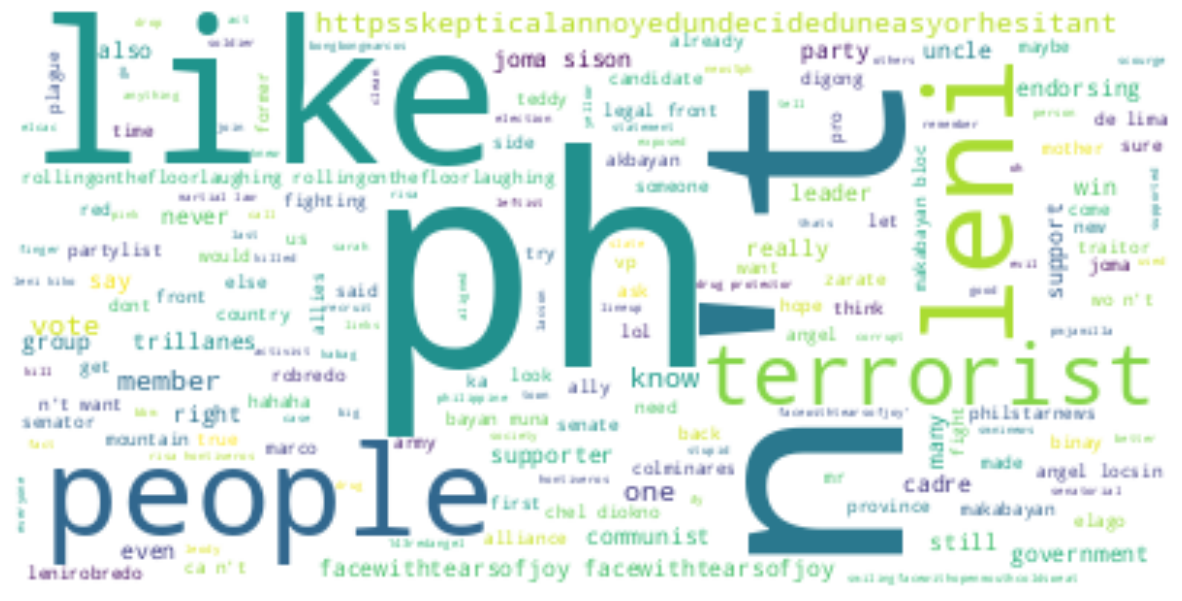

In [71]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
import matplotlib.pyplot as plt
tweet_compiled = str([''.join(word) for word in tweets_en_clean])

#to remove keywords such as Neri, Colmenares, etc
tweet_compiled = tweet_compiled.replace("neri","")
tweet_compiled = tweet_compiled.replace("colmenares","")
tweet_compiled = tweet_compiled.replace("npa","")
tweet_compiled = tweet_compiled.replace("cpp","")
tweet_compiled = tweet_compiled.replace("ndf","")
tweet_compiled = tweet_compiled.replace("neri colmenares","")
tweet_compiled = tweet_compiled.replace("colmenaresph","")

wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(tweet_compiled)
plt.figure( figsize=(15,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


After removing certain keywords, it can be seen that some of the stand out words include 'terrorist' as well as then presidential candidate Leni Robredo (leni).

In [72]:
!pip install -q transformers
from transformers import pipeline

### Sentiment Analysis
In addition to a word cloud, a basic sentiment analysis can be done to check the general sentiment of the tweets. In order to do this, a pre-trained sentiment analysis model from Hugging Face Hub  (huggingface.co) was used.

In [73]:
sentiment_pipeline = pipeline("sentiment-analysis")
results = sentiment_pipeline(tweets_en_clean)


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [74]:
df_sentiment = pd.DataFrame(results)

df_sentiment['label'].describe()
#df_sentiment.head().style.set_properties(**{'text-align': 'left'})

count          249
unique           2
top       NEGATIVE
freq           222
Name: label, dtype: object

it can be seen from the sentiment analysis that over 220 of the 249 were considered negative. Of the remaining 29, its 'positive' rating could still be brought into question given a more finely tuned model. Below are the results from the analysis, as well as a copy of the original tweets (for readability).

In [75]:
df_sentiment['Tweet'] = df_tweets['Tweet']
df_sentiment.head().style.set_properties(**{'text-align': 'left'})

,label,score,Tweet
0,NEGATIVE,0.994398,"@_ultravioletred @jersonality If their ED was done by a CPP cadre, the educator would've been reprimanded for sure. Whoever that educator is, they're probably still thinking in the 90s. Wake up kas, RA/RJ split is not that relevant anymore, lol. Embrace your comrades like what Neri, Labog, and Zarate did."
1,NEGATIVE,0.957633,@lukatmhe Colmenarez family ay part sa legal front ng NPA. At saka may first cousin si Angel Locsin na big time drug dealer ng shabu sa Cebu. Siya ay former Local Beauty Queen. Mismo si Neri Colmenarez naki usap sa mga police na wag galawin or itumba.
2,NEGATIVE,0.976526,"@weirdnow1 @pnagovph yay 😂😂😂 kaya pa nmn mag pakamatay yang sina Elago,Zarate,Colmenares,Nato Reyes sa pakiki bakbakan.Tanggaaa yung mga nasapi sa NPA"
3,NEGATIVE,0.988238,@ColmenaresPH Shut Up Colmenares NPA. SALOT KA #Nerveagain
4,NEGATIVE,0.993042,AHAHAHAHA neri niyo NPA


# Visualization
For this part of the EDA, we are expected to at least one plot of each of the following types:
- Scatter plots / histograms
- Heat maps 
- Bar / swarm / violin plots 
- Line graphs

### Time Series Analysis

Let's start by plotting the number of tweets against time, i.e., monthly, weekly, and daily. To make sure our data falls neatly into histogram bars,

- the monthly data will have the `Date Posted` column standardized to the first day of every month;
- the weekly data will be standardized to the first day of the week, where the first day of the first week is the day the earliest tweet was posted;
- the daily data will be standardized to midnight of each day.

In [76]:
# Create a copies of the dataframe for monthly, weekly, and daily analysis
df_monthly = df_new.copy()
df_monthly['Date Posted'] = pd.to_datetime(df_monthly['Date Posted'])
df_weekly = df_new.copy()
df_weekly['Date Posted'] = pd.to_datetime(df_weekly['Date Posted'])
df_daily = df_new.copy()
df_daily['Date Posted'] = pd.to_datetime(df_daily['Date Posted'])

# For monthly, set the date to the first of the month
df_monthly['Date Posted'] = df_monthly['Date Posted'].dt.strftime('%Y-%m-01')

# For weekly, set the date to the first of the week
df_weekly['Date Posted'] = df_weekly['Date Posted'] - pd.to_timedelta(df_weekly['Date Posted'].dt.dayofweek, unit='d')

# For daily, set the date to midnight
df_daily['Date Posted'] = df_daily['Date Posted'].dt.strftime('%Y-%m-%d 00:00:00')

Now that the data is standardized we can now create the histograms with Plotly.

In [77]:
# Plot the number of tweets per month
import plotly.express as px
fig = px.histogram(df_monthly, x='Date Posted', title='Number of Tweets per Month')
fig.update_xaxes(title_text='Month')
fig.update_yaxes(title_text='Tweets')
fig.update_layout(bargap=0.1)
fig.show()
fig.write_html("permonth.html")

In [78]:
# For the weekly and daily histograms, we'll need to tell plotly to properly
# format the histogram to show bars and ticks. For this we'll need to count
# the number of days and weeks that the dataset spans.
first_day = df_daily['Date Posted'].min()
last_day = df_daily['Date Posted'].max()
num_days = (pd.to_datetime(last_day) - pd.to_datetime(first_day)).days + 1
num_weeks = num_days // 7

# Now we plot the number of tweets per week...
fig = px.histogram(df_weekly, x='Date Posted', title='Number of Tweets per Week', nbins=num_weeks)
fig.update_xaxes(title_text='Week')
fig.update_yaxes(title_text='Tweets')
fig.update_layout(bargap=0.1, xaxis=dict(
  nticks = num_weeks
))
fig.show()
fig.write_html("perweek.html")

In [79]:
# ... and per day.
fig = px.histogram(
  df_daily,
  x='Date Posted',
  title='Number of Tweets per Day',
  nbins=num_days
)
fig.update_xaxes(title_text='Day', ticks='inside')
fig.update_yaxes(title_text='Tweets')
fig.update_layout(xaxis=dict(
  nticks = num_weeks
))
fig.show()
fig.write_html("perday.html")

#### Kernel density estimation

Same histograms as with the previous ones, but with a kernel density estimate plot so the distribution is easier to see.

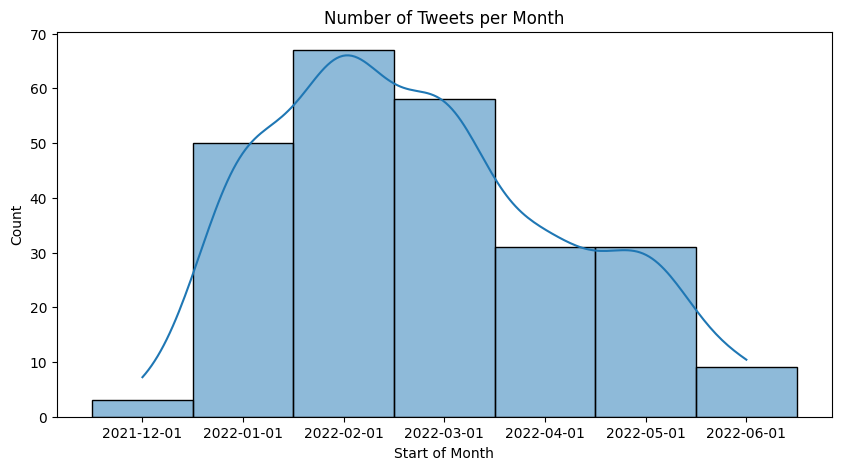

In [80]:
# Monthly
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
sns.histplot(df_monthly['Date Posted'], bins=12, kde=True)
plt.title('Number of Tweets per Month')
plt.xlabel('Start of Month')
plt.show()

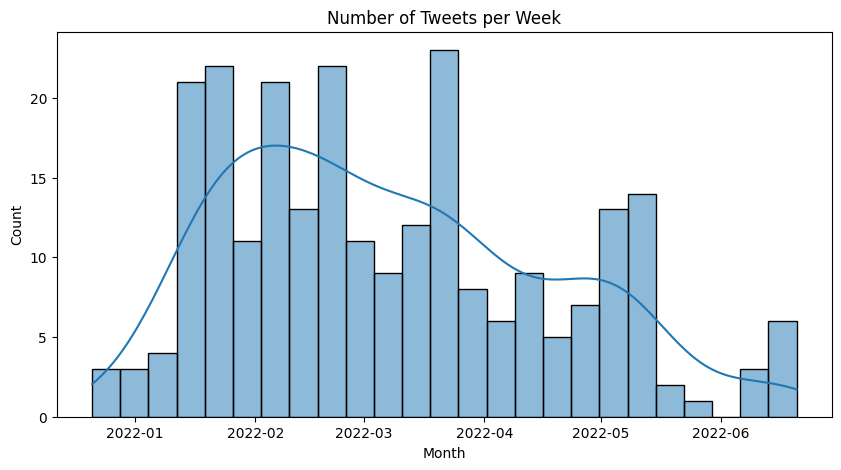

In [81]:
# Weekly
plt.figure(figsize=(10,5))
sns.histplot(df_weekly['Date Posted'], bins=num_weeks, kde=True)
plt.title('Number of Tweets per Week')
plt.xlabel('Month')
plt.show()

For the daily histplot, we'll need to feed Seaborn the data a little differently.

Since the dataset only contains tweets that exist, and that there are dates in the range where there were no tweets collected, `seaborn.histplot()` will not emit (zero-height) bars for those dates that are missing. This means that we'll have to impute the missing dates manually using tweet counts of `0`.

In [82]:
# Create a new dataframe with columns for date and tweet count
df_daily_all = pd.DataFrame(columns=['Date Posted', 'Num Tweets'])
df_daily_all['Date Posted'] = pd.date_range(first_day, last_day)
df_daily_all['Num Tweets'] = 0

# Count tweets per day in the original dataframe
for _, row in df_daily.iterrows():
  date = row['Date Posted']
  df_daily_all.loc[df_daily_all['Date Posted'] == date, 'Num Tweets'] += 1

df_daily_all.head().style.set_properties(**{'text-align': 'left'})

,Date Posted,Num Tweets
0,2021-12-26 00:00:00,1
1,2021-12-27 00:00:00,0
2,2021-12-28 00:00:00,1
3,2021-12-29 00:00:00,1
4,2021-12-30 00:00:00,0


Now we can use this dataframe with Seaborn. In the output below, `bw_adjust` is a multiplier for how smooth the resulting KDE plot is; a value of `1` leaves it at default smoothness.

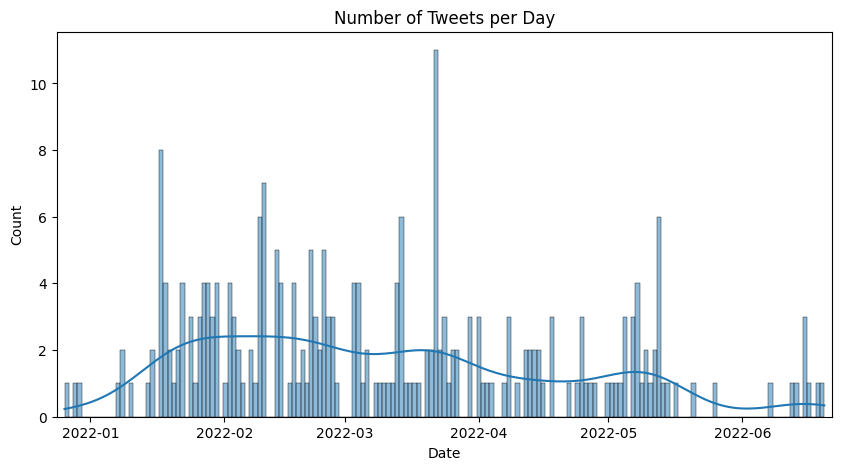

In [83]:
# bw_adjust controls the smoothness of the kde plot
bw_adjust = 0.5 #@param {type:"slider", min:0, max:2, step:0.01}

# Daily
plt.figure(figsize=(10,5))
sns.histplot(data=df_daily_all,
             x='Date Posted',
             weights='Num Tweets',
             bins=num_days,
             kde=True,
             kde_kws=dict(bw_adjust=bw_adjust))
plt.title('Number of Tweets per Day')
plt.xlabel('Date')
plt.margins(x=0.01)
plt.show()

#### Observations

**What is the frequency of the time series data (e.g. hourly, daily, weekly)?**

The tweets are recorded down to the minute, but we are able to gain more insight if we were to group them by day, week, and month, as we have seen in the histograms above.

**Is the time series data stationary, or does it have trends, cycles, or seasonality?**

The tweets span only about 6 months:

In [84]:
print('Dataset date range')
print('-'*30)
print('Start date: {}'.format(first_day))
print('End date: {}'.format(last_day))
print('Number of days: {}'.format(num_days))
print('Number of weeks: {}'.format(num_days / 7))

Dataset date range
------------------------------
Start date: 2021-12-26 00:00:00
End date: 2022-06-20 00:00:00
Number of days: 177
Number of weeks: 25.285714285714285


From the histplots there doesn't seem to be any recurring pattern or seasonality in the number of tweets over the given time period.

**Are there any outliers in the time series data?**

There is a noticeable peak on 22 March 2022 (11 tweets posted), although it does not seem to correlate with any major event in the country on that day.

**How do different parts of the time series data compare to each other (e.g. weekdays vs weekends)?**

Let's look at the cumulative number of tweets per day of the week (where the first day in the week, `0`, is [Monday](https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.dayofweek.html)):

<ipython-input-85-fded567a9b88>:20: UserWarning:

FixedFormatter should only be used together with FixedLocator



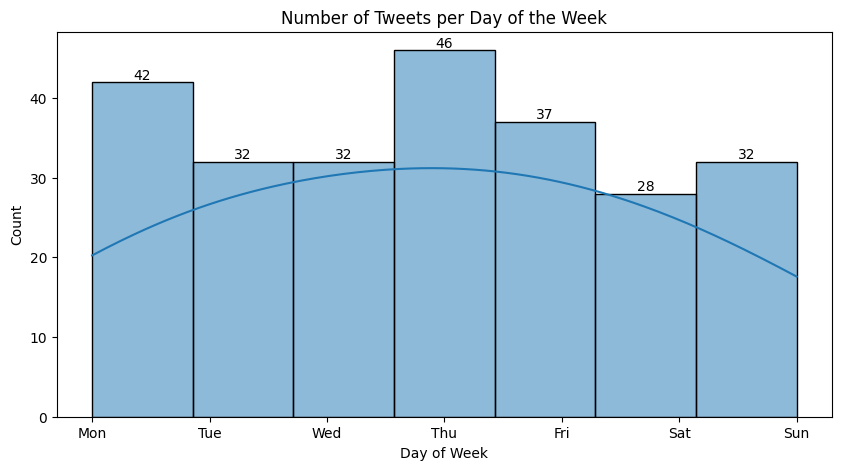

In [85]:
# Day of week
# Create a dataframe for day of week and number of tweets
df_dayofweek = pd.DataFrame(columns=['Day of Week', 'Num Tweets'])
df_dayofweek['Day of Week'] = range(7)
df_dayofweek['Num Tweets'] = 0
for _, row in df_new.iterrows():
  day = pd.to_datetime(row['Date Posted']).dayofweek
  df_dayofweek.loc[df_dayofweek['Day of Week'] == day, 'Num Tweets'] += 1

# Plot the number of tweets per day of the week
plt.figure(figsize=(10,5))
ax = sns.histplot(data=df_dayofweek,
                  x='Day of Week',
                  weights='Num Tweets',
                  bins=7, 
                  kde=True)
ax.bar_label(ax.containers[1])
plt.title('Number of Tweets per Day of the Week')
plt.xlabel('Day of Week')
ax.set_xticklabels(['', 'Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.show()

We can see from the histogram that the highest number of tweets was posted on a weekday (Thursday), while the lowest was on a weekend (Saturday).

We can also look at the number of tweets posted at each day of the month, across all months:

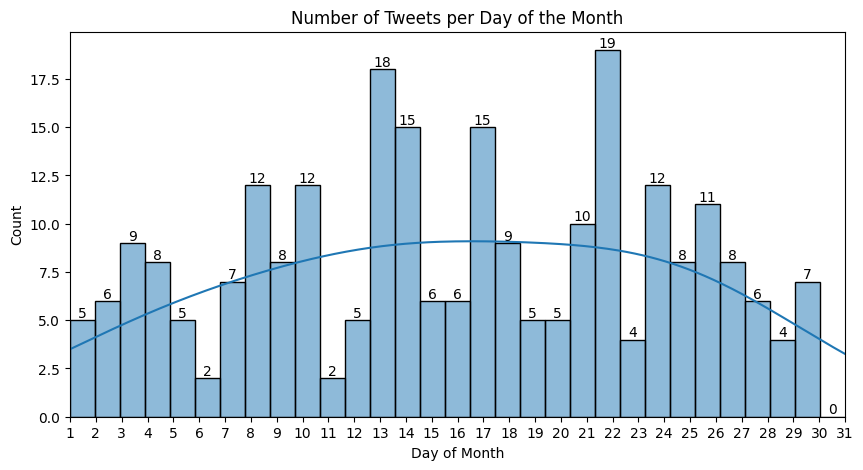

In [86]:
# Day of month
# Create a dataframe for day of month and number of tweets
df_dayofmonth = pd.DataFrame(columns=['Day of Month', 'Num Tweets'])
df_dayofmonth['Day of Month'] = range(1, 32)
df_dayofmonth['Num Tweets'] = 0
for _, row in df_new.iterrows():
  day = pd.to_datetime(row['Date Posted']).day
  df_dayofmonth.loc[df_dayofmonth['Day of Month'] == day, 'Num Tweets'] += 1

# Plot the number of tweets per day of the month
plt.figure(figsize=(10,5))
ax = sns.histplot(data=df_dayofmonth,
                  x='Day of Month',
                  weights='Num Tweets',
                  bins=31,
                  kde=True)
ax.bar_label(ax.containers[1])
plt.title('Number of Tweets per Day of the Month')
plt.xlabel('Day of Month')
plt.xlim(1, 31)
plt.xticks(range(1, 32))
plt.show()

We can observe that the tweets tend to have been posted around the middle of the month, with peaks at the 13th and the 22nd. Interestingly, across all 249 collected tweets, there were none that were posted on the 31st of the month, although this is not unexpected since not every month has a 31st day.

The KDE plots for both histograms resemble a normal distribution.

**Are there any significant events or changes in the time series data (e.g. sudden drops or spikes)?**

We can observe that the number of tweets taper off after the election on the 9th of May, 2022.

In [87]:
import plotly.express as px
import plotly.graph_objects as go
import datetime
import numpy as np

In [88]:
df_new.head().style.set_properties(**{'text-align': 'left'})

,ID,Account Type,Tweet,Tweet Type,Date Posted,Screenshot,Content Type,Tweet ID,Tweet Types,"Num Account Type (Anonymous, Identified, Media)","Num Tweet Type (Text, Image, URL, Reply)","Num Content Type (Emotional, Rational, Transactional)"
0,00-1,Identified,"@_ultravioletred @jersonality If their ED was done by a CPP cadre, the educator would've been reprimanded for sure. Whoever that educator is, they're probably still thinking in the 90s. Wake up kas, RA/RJ split is not that relevant anymore, lol. Embrace your comrades like what Neri, Labog, and Zarate did.",Reply,12/26/21 22:35,00-1.png,Rational,1475113095395966976,['Reply'],1,3,2
1,00-2,Identified,@lukatmhe Colmenarez family ay part sa legal front ng NPA. At saka my first cousin si Angel Locsin na big time drug dealer ng shabu sa Cebu. Siya at former Local Beauty Queen. Mismo si Neri Colmenarez naki usap sa mnga police na wag galawin or itumba.,Reply,12/28/21 13:25,00-2.png,Rational,1475699422982189056,['Reply'],1,3,2
2,00-3,Anonymous,"@weirdnow1 @pnagovph yay ðŸ˜‚ðŸ˜‚ðŸ˜‚ kaya pa nmn mag pakamatay yang sina Elago,Zarate,Colmenares,Nato Reyes sa pakiki bakbakan.Tanggaaa yung mga nasapi sa NPA",Reply,12/29/21 20:47,00-3.png,Emotional,1476173017458016256,['Reply'],0,3,0
3,00-4,Anonymous,@ColmenaresPH Shut Up Colmenares NPA. SALOT KA #Nerveagain,Reply,01/07/22 14:37,00-4.png,Emotional,1479341371219902464,['Reply'],0,3,0
4,00-5,Anonymous,AHAHAHAHA neri niyo NPA,Reply,01/08/22 06:25,00-5.png,Emotional,1479580070922846208,['Reply'],0,3,0


## Scatter Plot / Histograms

Since our project concerns itself with the distribution of tweets about Neri Colmenares' connections to the CPP-NDA-NDF, the most intuitive feature to plot is the amount of tweets over a particular period of time. 

To make this possible, we need to separate the date and time from the `Date Posted` column before plotting the frequency. 

In [89]:
def get_date(row):
  date = str(row['Date Posted'])
  return date[0:8]

df_new['Date'] = df_new.apply(lambda row: get_date(row), axis=1)
df_new['Date']

0      12/26/21
1      12/28/21
2      12/29/21
3      01/07/22
4      01/08/22
         ...   
244    02/14/22
245    02/01/22
246    02/13/22
247    02/23/22
248    03/03/22
Name: Date, Length: 249, dtype: object

Now, we can look at the frequency table of the number of tweets in a particular date.

In [90]:
# Turn Date to the appropriate type
df_new['Date'] = pd.to_datetime(df_new['Date'])

df_datefreq = df_new['Date'].value_counts().rename_axis('Date').reset_index(name='Frequency').sort_values(by='Date')
df_datefreq['Ones'] = 1
df_datefreq


,Date,Frequency,Ones
79,2021-12-26,1,1
102,2021-12-28,1,1
83,2021-12-29,1,1
84,2022-01-07,1,1
40,2022-01-08,2,1
...,...,...,...
70,2022-06-14,1,1
32,2022-06-16,3,1
60,2022-06-17,1,1
64,2022-06-19,1,1


**Displaying the Scatter Plot.** This scatter plot has dates on the x-axis and each circle on the graph is a date where at least one tweet was made. The size of each one represents the number of tweets on that date. 

When viewed through Colab, you may interact with the graph by hovering onto each circle, displaying the date and the frequency for that day.

This gives us an idea of the spread of the data, showing that the tweets are clustered between mid-January to late February 2022 and again throughout March 2022.

In [91]:
# plotting the scatter chart
scatter = px.scatter(df_datefreq, x='Date', y='Ones', size='Frequency',
                              hover_data={'Ones':False}, height = 300,
                              title = "Scatter Plot of Dates and Frequency of Tweets")
scatter.update_yaxes(visible=False)
scatter.update_layout(yaxis_range=[1,1])
 
# showing the plot
scatter.show()
scatter.write_html("scatterplot.html")

**Displaying the histogram.** The histogram shows us similar data, showing the spread of tweets across the dates included in this project. The histogram gives us an opportunity to break down the frequency for each account type since we can divide the bar into each of the segments.

When viewed through Colab, you may interact with the graph through clicking each of the colors in the legend to isolate their traces.

The graph below shows the number of tweets on each given day for each account type. From the heights of the bars, we find that the tweets are mostly from accounts classified as `Anonymous` and that they often constitute the majority of the tweets for most days.

In [92]:
# plotting the histogram
histo = px.histogram(df_new, x='Date', color='Account Type', nbins = 100,
                            title = "Histogram of Dates and Frequency of Tweets with respect to Account Type",
                            hover_data={'Date':True, # remove species from hover data
                             'Account Type':False
                            })

histo.update_layout(
    title="Histogram of Dates and Frequency of Tweets with respect to Account Type",
    yaxis_title="Number of Tweets",
    xaxis_title="Dates",
    legend_title="Account Type",
)

# showing the plot
histo.show()
histo.write_html("histogram.html")

## Heat Maps

In the same way the intuitive scatter plot is that which shows the amount of tweets over time, we can do the same for heat maps. This shows us the same correlation as those above but is a lot more visual in showing the density of Tweets over a particular date.

When viewed through Colab, you may interact with the graph by hovering on each of the strips which displays the date and tweet count for that day.

In [93]:
z = [list(df_datefreq['Frequency'])]
x = df_datefreq['Date']
y = [1]

hovertext = list()
for yi, yy in enumerate(y):
    hovertext.append(list())
    for xi, xx in enumerate(x):
        hovertext[-1].append('Date: {}<br />Tweet Count: {}'.format(xx.strftime("%d %b %y"), z[yi][xi]))

heatmap = go.Figure(data=go.Heatmap(
        z=z,
        x=x,
        y=y,
        colorscale = 'teal',
        hoverinfo='text', text=hovertext))

heatmap.update_xaxes(title_text='Date')
heatmap.update_yaxes(visible=False)
heatmap.update_layout(title_text='Heatmap of Tweets per Day')

heatmap.show()
heatmap.write_html("heatmap.html")

## Bar / swarm / violin plots 

Unlike the Histogram which displays data in some way it can be ordered, the Bar graph shows the frequency of occurrences of some categorical data.

In the graph below, we show the number of tweets for each Account Type and the corresponding segments representing the Tweet Types.

When viewed through Colab, you can isolate each Tweet Type by clicking on it at the legend.

In [94]:
count_series = df_new.groupby(['Account Type', 'Tweet Type']).size()
df_bar = count_series.to_frame(name = 'Frequency').reset_index()

bargraph = px.bar(df_bar, x='Account Type', y = 'Frequency', color='Tweet Type', title="Bar Graph of Tweets per Account Type with respect to Tweet Type")
bargraph.update_yaxes(title_text='Tweet Count')

bargraph.show()
bargraph.write_html("bargraph.html")

## Line graphs

With line graphs, we're able to see the increase or decrease in frequency as time passes. For the graph below, we plotted the number of tweets for each of the types relative to the date. We find an increasing set of peaks in the frequency of Reply tweets from early to mid-March and can clearly find windows of time where there as at least one tweet a day since they form distinct shapes against the x-axis.

When viewed through Colab, you can interact with the graph by isolating the trace for each of the Tweet Types by clicking them on the legend.

In [95]:
count_series = df_new.groupby(['Date', 'Tweet Type']).size()
df_bar = count_series.to_frame(name = 'Frequency').reset_index()

linegraph = px.line(df_bar, x='Date', y = 'Frequency', color='Tweet Type', title="Line Graph of Tweet Type over Date")
linegraph.update_yaxes(title_text='Tweet Count')

linegraph.show()
linegraph.write_html("linegraph.html")